In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
from matplotlib import pyplot as plt

### system imports 

In [5]:
import pathlib
import sys
import os 
import time 
import pickle
import time 
from datetime import timedelta

### get current directory 


In [6]:
CWD = pathlib.Path.cwd()

In [7]:
HOME = pathlib.Path.home()

### add the path to the custom functions

In [8]:
sys.path.append(str(HOME.joinpath('research/dl4seas/dl4seas/')))

In [9]:
from NN import *
from utils import *

### Scientific Stack 

In [10]:
import numpy as np 
import pandas as pd 
import xarray as xr

### Tensorflow and Keras 

In [11]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

### set the random seeds for reproducible results 

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

### check if the GPU is available 

In [13]:
if len(tf.config.list_physical_devices('GPU')) >= 1: 
    compute = 'GPU'
else: 
    compute = 'CPU'

In [14]:
compute

'CPU'

### Loads and prepare the data 

In [15]:
dpath_vcsn = '/media/nicolasf/END19101/data/VCSN/'
dpath_gcm = '/media/nicolasf/END19101/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/'

### target (VCSN)

In [16]:
var_name = "TMEAN"

In [17]:
if "TMEAN" in var_name:
    dpath = pathlib.Path(f"{dpath_vcsn}/{var_name.replace('_N','')}/seasonal_anomalies_VCSN_{var_name}_N.nc")
elif "RAIN" in var_name:
    dpath = pathlib.Path(f"{dpath_vcsn}/{var_name.replace('_BC','')}/seasonal_anomalies_VCSN_{var_name}_BC.nc")

In [18]:
vcsn = xr.open_dataset(dpath) 

In [19]:
vcsn = vcsn[['Tmean_N']]

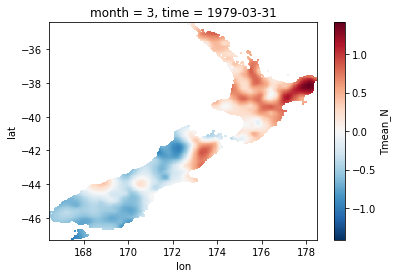

In [21]:
vcsn.isel(time=0)['Tmean_N'].plot()

### read the GCM data 

In [22]:
lfiles = list_files(dpath_gcm, pattern="ECMWF_T2M_seasonal_anomalies", extension=".nc", exclude='interp', verbose=1)

loaded files, list length 288
the first file is /media/nicolasf/END19101/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/ECMWF_T2M_seasonal_anomalies_1993_01.nc
the last file is /media/nicolasf/END19101/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/ECMWF_T2M_seasonal_anomalies_2016_12.nc


### read the multiple files data set using xarray and dask, not that it will not be loaded in RAM

In [23]:
gcm = xr.open_mfdataset(lfiles, concat_dim='time', combine='nested', parallel=True)

In [24]:
gcm.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:     (lat: 181, lon: 360, member: 25, step: 3, time: 288)
Coordinates:
    surface     int64 0
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * member      (member) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * step        (step) int64 3 4 5
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(1, 3), meta=np.ndarray>
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m         (time, member, step, lat, lon) float32 dask.array<chunksize=(1, 25, 3, 181, 360), meta=np.ndarray>>

### selects the training set 

In [25]:
gcm_train = gcm.sel(time=slice('1993','2010'))[['t2m']]

### selects the validation set 

In [26]:
gcm_val = gcm.sel(time=slice('2011','2015'))[['t2m']]

### keep one year for testing 

In [27]:
gcm_test = gcm.sel(time='2016')[['t2m']]

**prepare the data**: 
    
    1) select the step (leadtime)
    2) to increase the size of the training and validation sets, consider each member as an instance (stacking along the time and member dimension)
    3) transpose to have the instances as the first dimension

In [28]:
def prep_data(ds): 
    ds = ds[['t2m']].sel(step=3)
    ds = ds.stack(instance=('time','member'))
    ds = ds.transpose('instance','lat','lon')
    return ds

In [29]:
gcm_train, gcm_val, gcm_test = map(prep_data, [gcm_train, gcm_val, gcm_test])

In [30]:
rdatetimes_train = gcm_train.indexes["instance"].get_level_values(0)

In [31]:
rdatetimes_val = gcm_val.indexes["instance"].get_level_values(0)

In [32]:
rdatetimes_test = gcm_test.indexes["instance"].get_level_values(0)

### shift the VCSN time 

In [33]:
vcsn.time[0]

<xarray.DataArray 'time' ()>
array('1979-03-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    month    int64 ...
    time     datetime64[ns] 1979-03-31

In [34]:
vcsn.time[-1]

<xarray.DataArray 'time' ()>
array('2019-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    month    int64 ...
    time     datetime64[ns] 2019-12-31

In [35]:
vcsn['time'] = shift_time(vcsn.time.to_index(), shift='Month Begin')

In [36]:
vcsn.time[0]

<xarray.DataArray 'time' ()>
array('1979-03-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    month    int64 ...
    time     datetime64[ns] 1979-03-01

In [37]:
vcsn['time'][-1]

<xarray.DataArray 'time' ()>
array('2019-12-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    month    int64 ...
    time     datetime64[ns] 2019-12-01

In [38]:
vcsn_train = vcsn.sel(time=rdatetimes_train)

In [39]:
vcsn_val = vcsn.sel(time=rdatetimes_val)

In [40]:
vcsn_test = vcsn.sel(time=rdatetimes_test)

### rename 'time' to 'instance' in vcsn

In [41]:
vcsn_train, vcsn_val, vcsn_test = map(lambda x: x.rename({'time':'instance'}), [vcsn_train, vcsn_val, vcsn_test])

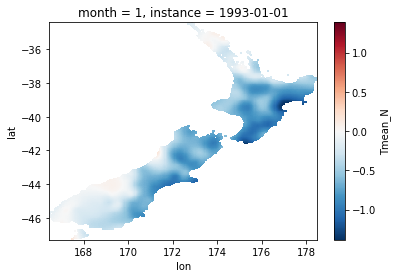

In [43]:
vcsn_train.isel(instance=0)['Tmean_N'].plot()

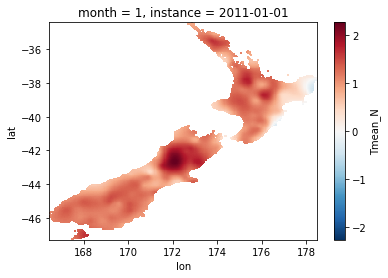

In [44]:
vcsn_val.isel(instance=0)['Tmean_N'].plot()

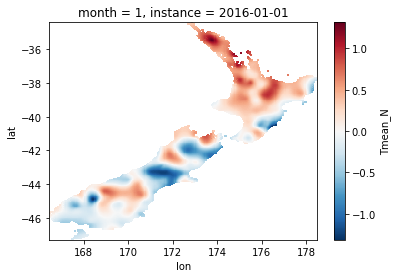

In [45]:
vcsn_test.isel(instance=0)['Tmean_N'].plot()

### Now checks if everything is OK 

In [46]:
gcm_train.dims

Frozen(SortedKeysDict({'lat': 181, 'lon': 360, 'instance': 5400}))

In [47]:
vcsn_train.dims

Frozen(SortedKeysDict({'lat': 257, 'lon': 241, 'instance': 5400}))

### define the parameters for the model

In [49]:
batch_size = 32

### preparing the data

#### not that it takes ages because of the repeated instances, maybe write a more general DataGenerator Class that just takes the already transformed xarray datasets ... 

In [50]:
data_train = XrDataGenerator(gcm_train, vcsn_train, {'t2m':None}, 'Tmean_N', \
                             norm=True, batch_size=batch_size, \
                             mean=None, std=None, shuffle=True, load=False, Y_flatten=True, Y_dropna=True)

In [51]:
data_val = XrDataGenerator(gcm_val, vcsn_val, {'t2m':None}, 'Tmean_N', \
                           norm=True, batch_size=batch_size, \
                           mean=data_train.mean, std=data_train.std, shuffle=True, load=False, Y_flatten=True, Y_dropna=True)

In [52]:
data_test = XrDataGenerator(gcm_test, vcsn_test, {'t2m':None}, 'Tmean_N', \
                            norm=True, batch_size=batch_size, \
                            mean=data_train.mean, std=data_train.std, shuffle=True, load=False, Y_flatten=True, Y_dropna=True)

### checks the shapes 

In [53]:
data_train[0][0].shape

(32, 181, 360, 1)

In [54]:
data_train[0][1].shape

(32, 11491, 1)

In [55]:
data_val[0][0].shape

(32, 181, 360, 1)

In [56]:
data_val[0][1].shape

(32, 11491, 1)

In [57]:
data_test[0][0].shape

(32, 181, 360, 1)

In [58]:
data_test[0][1].shape

(32, 11491, 1)

### load the model 

In [60]:
# del(AE)

In [61]:
AE = keras.models.load_model('./saved_autoencoder_ConvAE_wo_MaxPooling_ECMWF_T2M_run_2020_08_19-14_52_16_20_epochs_GPU_fullCNN/')

In [62]:
# # %% Input
# original = Input(shape=input_shape)

# # Resize to have dimensions divisible by 8 (the padding)
# resized = ResizeLayer(newsize=resize_shape)(original)

# # # Wrap-around in longitude for periodic boundary conditions

# padded = PeriodicPadding2D(padd)(resized)

# # Encoding layers
# x = Conv2D(16, (3, 3), padding='same')(padded)
# x = LeakyReLU()(x)
# x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
# x = LeakyReLU()(x)
# x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
# x = LeakyReLU()(x)
# x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
# x = LeakyReLU()(x)

In [63]:
model = keras.models.Sequential(AE.layers[:9])

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resize_layer (ResizeLayer)   (None, 184, 360, 1)       0         
_________________________________________________________________
periodic_padding2d (Periodic (None, 200, 376, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 376, 16)      160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200, 376, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 187, 8)        1160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 99, 187, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 93, 8)         5

In [65]:
model.add(Flatten(input_shape=[49,93,8]))

In [66]:
# model.add(Dense(1000, activation='relu'))

In [67]:
# model.add(Dense(5000, activation='relu'))

In [68]:
model.add(Dense(11491))

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resize_layer (ResizeLayer)   (None, 184, 360, 1)       0         
_________________________________________________________________
periodic_padding2d (Periodic (None, 200, 376, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 376, 16)      160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200, 376, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 187, 8)        1160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 99, 187, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 93, 8)         5

In [70]:
model.compile(optimizer='adam', loss='mean_squared_error') 

In [71]:
n_epochs = 5

In [72]:
history = model.fit(data_train, validation_data=data_val, epochs=n_epochs) 

Epoch 1/5
169/169 [==============================] - 265s 2s/step - loss: 8.5457 - val_loss: 0.4613
Epoch 2/5
169/169 [==============================] - 272s 2s/step - loss: 0.2794 - val_loss: 0.4466
Epoch 3/5
169/169 [==============================] - 285s 2s/step - loss: 0.2162 - val_loss: 0.4509
Epoch 4/5
169/169 [==============================] - 290s 2s/step - loss: 0.1686 - val_loss: 0.4561
Epoch 5/5
169/169 [==============================] - 286s 2s/step - loss: 0.1405 - val_loss: 0.5268


<AxesSubplot:>

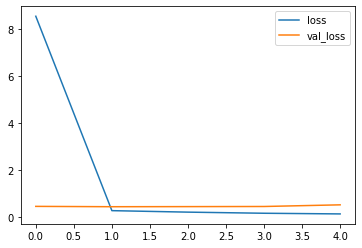

In [73]:
pd.DataFrame(history.history).plot()

In [74]:
preds_val = model.predict(data_val[1][0])

In [75]:
preds_val.shape

(32, 11491)

In [76]:
data_val[1][1].shape

(32, 11491, 1)

In [79]:
vcsn_val_inst = vcsn_val.isel(instance=0)

In [80]:
vcsn_val_inst

<xarray.Dataset>
Dimensions:   (lat: 257, lon: 241)
Coordinates:
  * lon       (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
    month     int64 ...
    instance  datetime64[ns] 2011-01-01
  * lat       (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
Data variables:
    Tmean_N   (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [81]:
vcsn_val_inst_stack = vcsn_val_inst.stack(z=('lat','lon'))

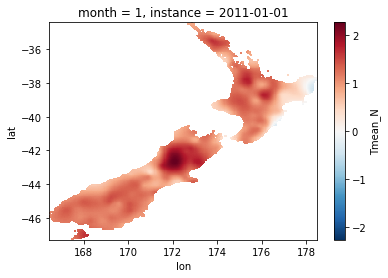

In [82]:
vcsn_val_inst_stack.unstack()['Tmean_N'].plot()

In [83]:
data = vcsn_val_inst_stack['Tmean_N'].data

In [84]:
pred_inst = preds_val[0,]

In [85]:
pred_inst.shape

(11491,)

In [86]:
datac = data.copy()

In [87]:
datac[~np.isnan(datac)] = pred_inst

In [88]:
vcsn_val_inst_stack['Tmean_N'] = (('z'), datac)

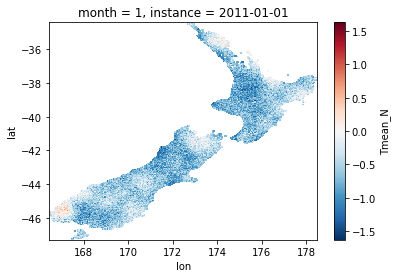

In [89]:
vcsn_val_inst_stack.unstack()['Tmean_N'].plot()

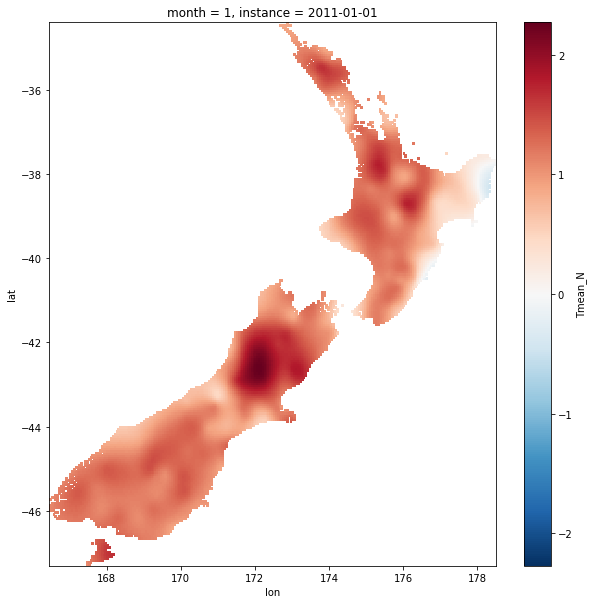

In [90]:
vcsn_val.isel(instance=0)['Tmean_N'].plot(figsize=(10,10))